In [29]:
import warnings
%load_ext autoreload
%autoreload 2
warnings.simplefilter('ignore')

# "chr=conceded-home-rolling"
# "car=conceded-away-rolling"
# "hr=home-rolling"
# "ar=away-rolling"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of features failed: Traceback (most recent call last):
  File "/Users/home2/.conda/envs/py38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/home2/.conda/envs/py38/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/home2/.conda/envs/py38/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/home2/Documents/PROJECTS/premier_league_match_predictions/features.py", line 87
    data.season=
           

In [31]:
from preprocess import pack
from features import Features, feature_selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import optimization
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from collections import OrderedDict
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
import pandas as pd
import seaborn as sns

In [32]:
feat = Features(**pack)
data = feat.execute()
container = feature_selection(data)
trainx = container.trainx
trainy = container.trainy

def encoder(data,feat):
    from sklearn.preprocessing import OrdinalEncoder
    oe=OrdinalEncoder()
    data[feat]=oe.fit_transform(data[feat])
    return data

trainx=encoder(trainx,['hometeam','awayteam','referee'])
# best_params = optimization.optimizer(
    # trainx.iloc[:10], trainy.iloc[:10], 'XGBoost_classif')


In [33]:
trainx.iloc[:10]

from sklearn.preprocessing import LabelEncoder


,season,referee,hometeam,awayteam,ftg_hr,htg_hr,s_hr,st_hr,c_hr,f_hr,...,htg_car,s_car,st_car,c_car,f_car,y_car,r_car,p_car,hp_car,day
0,2000-01,122.0,12.0,25.0,0.666667,0.333333,11.000000,3.666667,4.166667,10.000000,...,0.4,9.3,5.2,4.8,10.4,1.2,0.2,1.1,1.3,6
1,2000-01,54.0,13.0,41.0,1.000000,0.166667,7.833333,3.166667,3.166667,10.166667,...,1.1,13.4,6.3,5.7,12.8,1.7,0.0,2.0,2.1,6
2,2000-01,15.0,14.0,27.0,2.500000,1.166667,13.000000,5.500000,4.166667,10.500000,...,0.7,9.7,3.2,5.3,16.2,2.9,0.1,0.5,1.0,6
3,2000-01,10.0,16.0,34.0,1.500000,0.666667,8.666667,4.166667,5.000000,10.166667,...,0.4,7.9,4.5,5.1,14.1,1.6,0.1,0.4,0.6,6
4,2000-01,38.0,22.0,17.0,0.833333,0.000000,8.000000,3.333333,4.333333,11.666667,...,0.6,11.8,4.7,6.4,12.9,1.7,0.0,1.3,0.8,6
5,2000-01,91.0,23.0,1.0,1.500000,0.500000,11.666667,4.166667,6.166667,11.166667,...,0.2,11.9,4.8,6.9,9.8,1.8,0.0,1.2,0.9,6
6,2000-01,108.0,24.0,7.0,1.166667,0.166667,12.500000,4.666667,6.500000,9.000000,...,1.2,12.2,6.4,6.8,11.6,1.6,0.0,2.4,1.9,6
7,2000-01,135.0,36.0,0.0,0.666667,0.500000,8.333333,3.333333,2.166667,14.333333,...,0.3,11.2,4.2,4.4,12.2,2.1,0.0,1.1,1.1,6
8,2000-01,9.0,38.0,21.0,0.333333,0.000000,6.166667,1.333333,2.666667,8.500000,...,1.0,13.5,5.8,5.0,10.5,1.3,0.0,2.2,1.6,6
9,2000-01,136.0,26.0,28.0,1.666667,0.500000,17.666667,5.666667,7.666667,8.166667,...,1.2,14.6,6.4,6.2,12.7,1.3,0.0,1.8,2.2,7


In [31]:

# best_params = OrderedDict([('colsample_bytree', 1.0),
#                            ('learning_rate', 0.14006304478391782),
#                            ('max_depth', 10),
#                            ('n_estimators', 50),
#                            ('subsample', 1.0)])





model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist',objective='multi:softprob' ,
                       eval_metric=accuracy_score, verbosity=0, **best_params)


def train(trainx, trainy):
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    train_acc, val_acc = [], []
    
    
    for k, (train_idx, val_idx) in enumerate(skf.split(trainx, trainy)):
        model.fit(trainx.iloc[train_idx].values, trainy.iloc[train_idx].values)
        train_preds = model.predict(trainx.iloc[train_idx].values)
        val_preds = model.predict(trainx.iloc[val_idx].values)
        
        acc_t = accuracy_score(
            y_true=trainy.iloc[train_idx].values, y_pred=train_preds)
        acc_v = accuracy_score(
            y_true=trainy.iloc[val_idx].values, y_pred=val_preds)
        train_acc.append(acc_t)
        val_acc.append(acc_v)
    return np.mean(train_acc), np.mean(val_acc)


In [32]:
# import features
# best = features.auto_best_features(trainx, trainy, n_features=30)
trainx,valx,trainy,valy=train_test_split(trainx,trainy)

In [33]:
trainx.reset_index(inplace=True,drop=True)
trainy.reset_index(inplace=True,drop=True)


In [34]:
model.fit(trainx,trainy)
t_preds=model.predict(trainx)
v_preds=model.predict(valx)


from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_preds,trainy))
print(f1_score(t_preds,trainy,average='weighted'))
print(recall_score(t_preds,trainy,average='weighted'))
print(precision_score(t_preds,trainy,average='weighted'))

[[1120  304  472]
 [ 693 2523 1103]
 [   0    1    0]]
0.6747762385564946
0.586068211068211
0.8083123674112912


In [29]:
print(confusion_matrix(v_preds,valy))
print(f1_score(v_preds,valy,average='weighted'))
print(recall_score(v_preds,valy,average='weighted'))
print(precision_score(v_preds,valy,average='weighted'))

[[267 107 128]
 [123 527 184]
 [ 67  82  69]]
0.5771379548782624
0.5553410553410554
0.6091527018753423


In [35]:
# mi = features.mutual_information(best, trainy)
# features.plotmi(mi)

In [39]:
# train_acc,val_acc=train(best, trainy)
# train_acc,val_acc



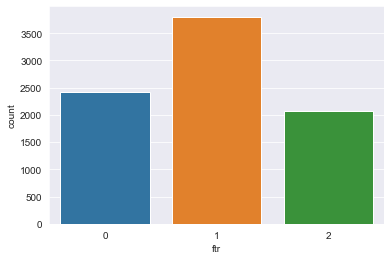

In [80]:
sns.countplot(trainy);

In [82]:
train(trainx,trainy)

(0.9823862979360414, 0.5702755779327867)

In [ ]:
# find the optimal parameters and by training and validating multiple times -the training and validation can be daone in loop or in single sert

In [16]:
import torch
from torch.utils.data import DataLoader

class Loader:
    def __init__(self,x,y):
        self.trainx=x.values
        self.trainy=y.values
    def __len__(self):
        return len(self.trainx)
    def __getitem__(self,idx):
        return {'x':self.trainx[idx],'y':self.trainy[idx]}
    


In [55]:
epochs=10
t_x,v_x,t_y,v_y=train_test_split(trainx,trainy,test_size=0.2)
trainloader=DataLoader(Loader(t_x,t_y),batch_size=64)
val_loader=DataLoader(Loader(v_x,v_y),batch_size=8)
best_params = OrderedDict([('colsample_bytree', 1.0),
                           ('learning_rate', 0.14006304478391782),
                           ('max_depth', 10),
                           ('n_estimators', 50),
                           ('subsample', 1.0)])
model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist', eval_metric='mlogloss', objective='multi:softprob' ,verbosity=0, **best_params)
model.fit(t_x,t_y)